In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import random

pd.options.display.max_columns = 1000

In [58]:
# Latent Dirichlet Allocation (LDA) Model using scikit-learn
catalog_data = pd.read_csv('./datasets/cleaned-catalog.csv')
job_data = pd.read_csv('./datasets/cleaned-job-descriptions.csv')

catalog_stopwords = nltk.corpus.stopwords.words('english')
job_stopwords = nltk.corpus.stopwords.words('english')

# add custom stopwords for course descriptions
catalog_stopwords.extend(['see', 'prerequisite', 'hour', 'hours', 'freshman', 'sophomore', 'junior', 'senior', 'standing', 'credit', 'consent', 'equivalent', 'undergraduate', 'graduate', \
                           'may', 'taken', 'course', 'courses', 'students', 'student', 'topics', 'include', 'includes', 'including', 'introduction', 'repeated', 'intended', \
                            'su', 'eps', 'instructor', 'section', 'one', 'vary', 'maximum', 'degree', 'program', 'department', 'register', 'per', 'term', 'terms', 'registration', \
                            'completed', 'concurrently', 'enrolled', 'enrollment', 'approved', 'letter', 'grading', 'major', 'majors', 'fees', 'apply', 'illinois', 'andor', 'passing' \
                            'summer', 'carle', 'concurrent', 'class', 'week', 'semester', 'semesters', 'required', 'using', 'examine', 'examines', 'restricted', 'phase', 'separate', \
                            'use', 'departmental', 'approval', 'offered', 'years', 'college', 'must', 'given', 'faculty', 'new', 'prerequisites', 'areas', 'offerings', 'schedule', \
                            'part' 'level', 'continuation', 'toward', 'whose', 'additional', 'gpa', 'degrees', 'enables', 'identical', 'except', 'curriculum', 'subject'])
# should add each subject as a stopword since they are mentioned in the descriptions
for subject in catalog_data['Subject'].unique():
    catalog_stopwords.append(subject.lower())

job_stopwords.extend(['new', 'one', 'must', 'job', 'per', 'ceo'])



# Create a vectorizer for LDA
catalog_vectorizer = CountVectorizer(stop_words=catalog_stopwords, max_df=0.95, min_df=2)
course_count_data = catalog_vectorizer.fit_transform(catalog_data['Description'])

job_vectorizer = CountVectorizer(stop_words=job_stopwords, max_df=0.95, min_df=0.01)
job_count_data = job_vectorizer.fit_transform(job_data['job_description'])


n_topics = 10
course_lda = LatentDirichletAllocation(n_components=n_topics)
course_lda.fit(course_count_data)

job_lda = LatentDirichletAllocation(n_components=n_topics)
job_lda.fit(job_count_data)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print("\t" + " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
print("Course Topics:\n")
display_topics(course_lda, catalog_vectorizer.get_feature_names_out(), no_top_words)
print("\nJob Topics:\n")
display_topics(job_lda, job_vectorizer.get_feature_names_out(), no_top_words)

Course Topics:

Topic 0:
	social cultural historical history issues media culture political study american
Topic 1:
	design research techniques dance writing composition methods project creative process
Topic 2:
	music applied level audition instruction performance jazz prior initial completion
Topic 3:
	systems information laboratory engineering biology chemistry principles veterinary existing energy
Topic 4:
	science materials environmental issues global natural international human studies economic
Topic 5:
	analysis theory methods design models problems techniques business applications systems
Topic 6:
	research study individual special professional topic thesis current honors member
Topic 7:
	project work study experience skills reading writing completion written language
Topic 8:
	professional management development skills education learning practice planning teaching work
Topic 9:
	data professional medicine health clinical learn care methods programming analysis

Job Topics:

To

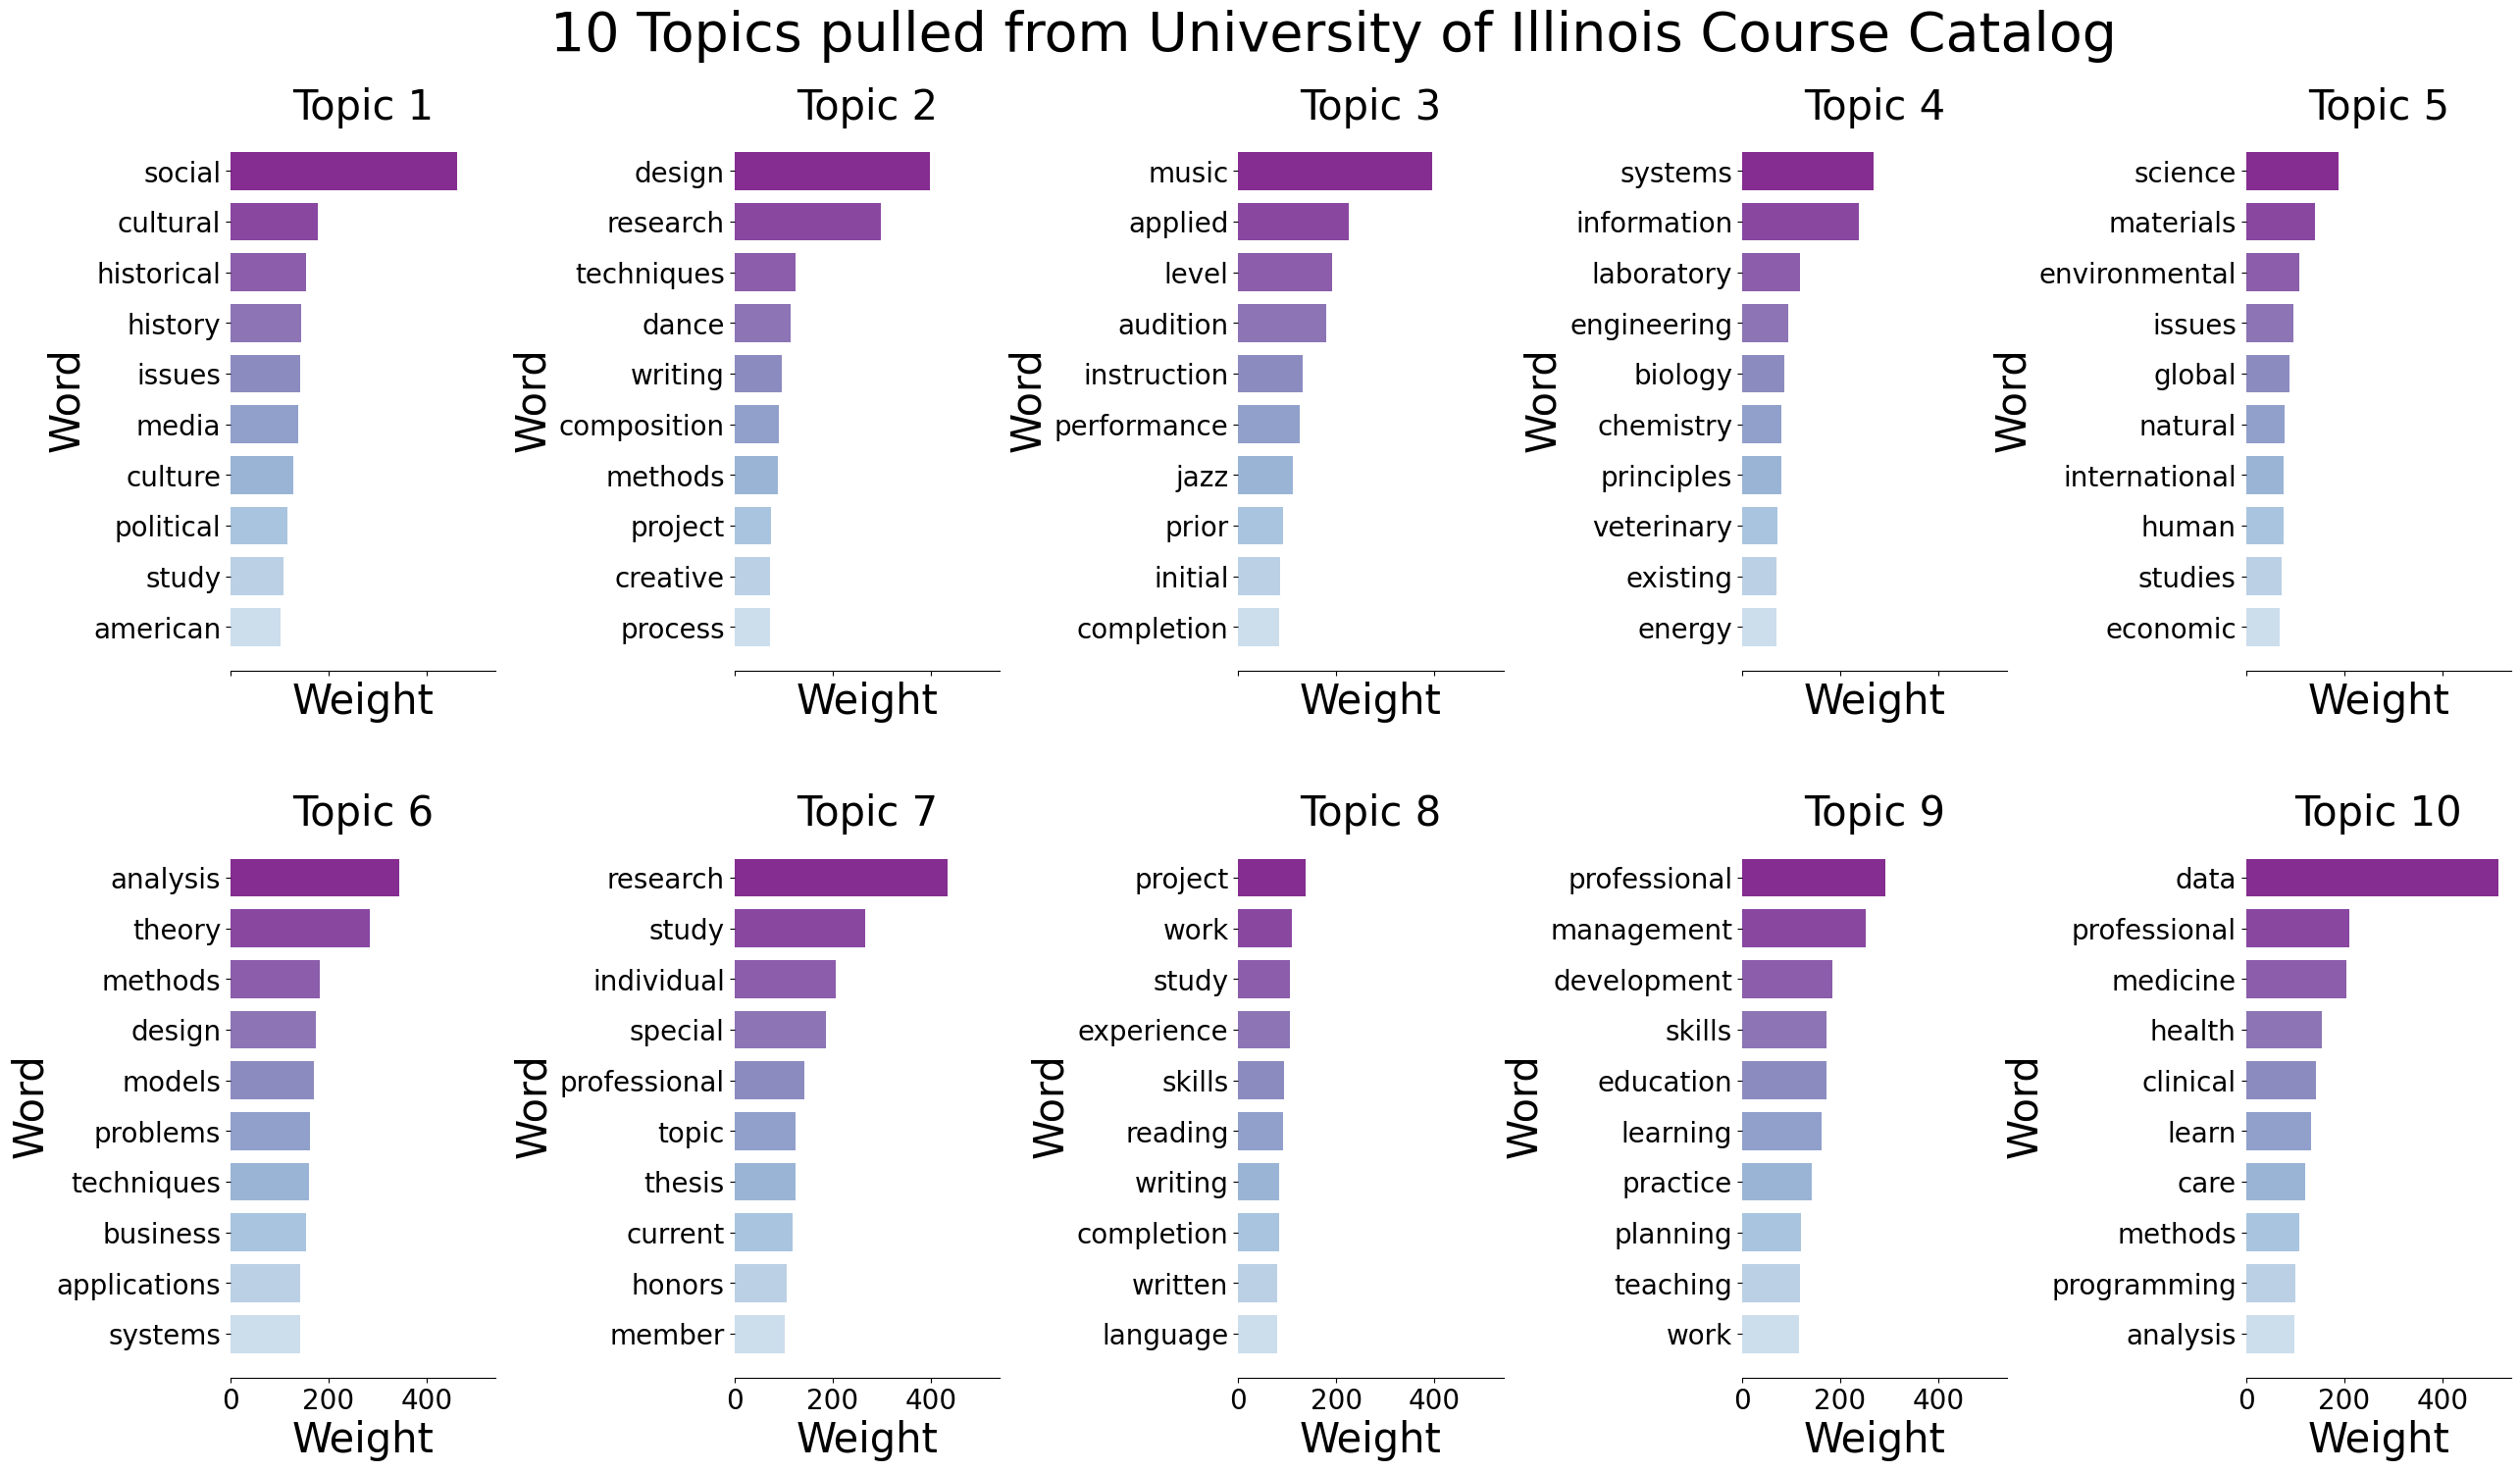

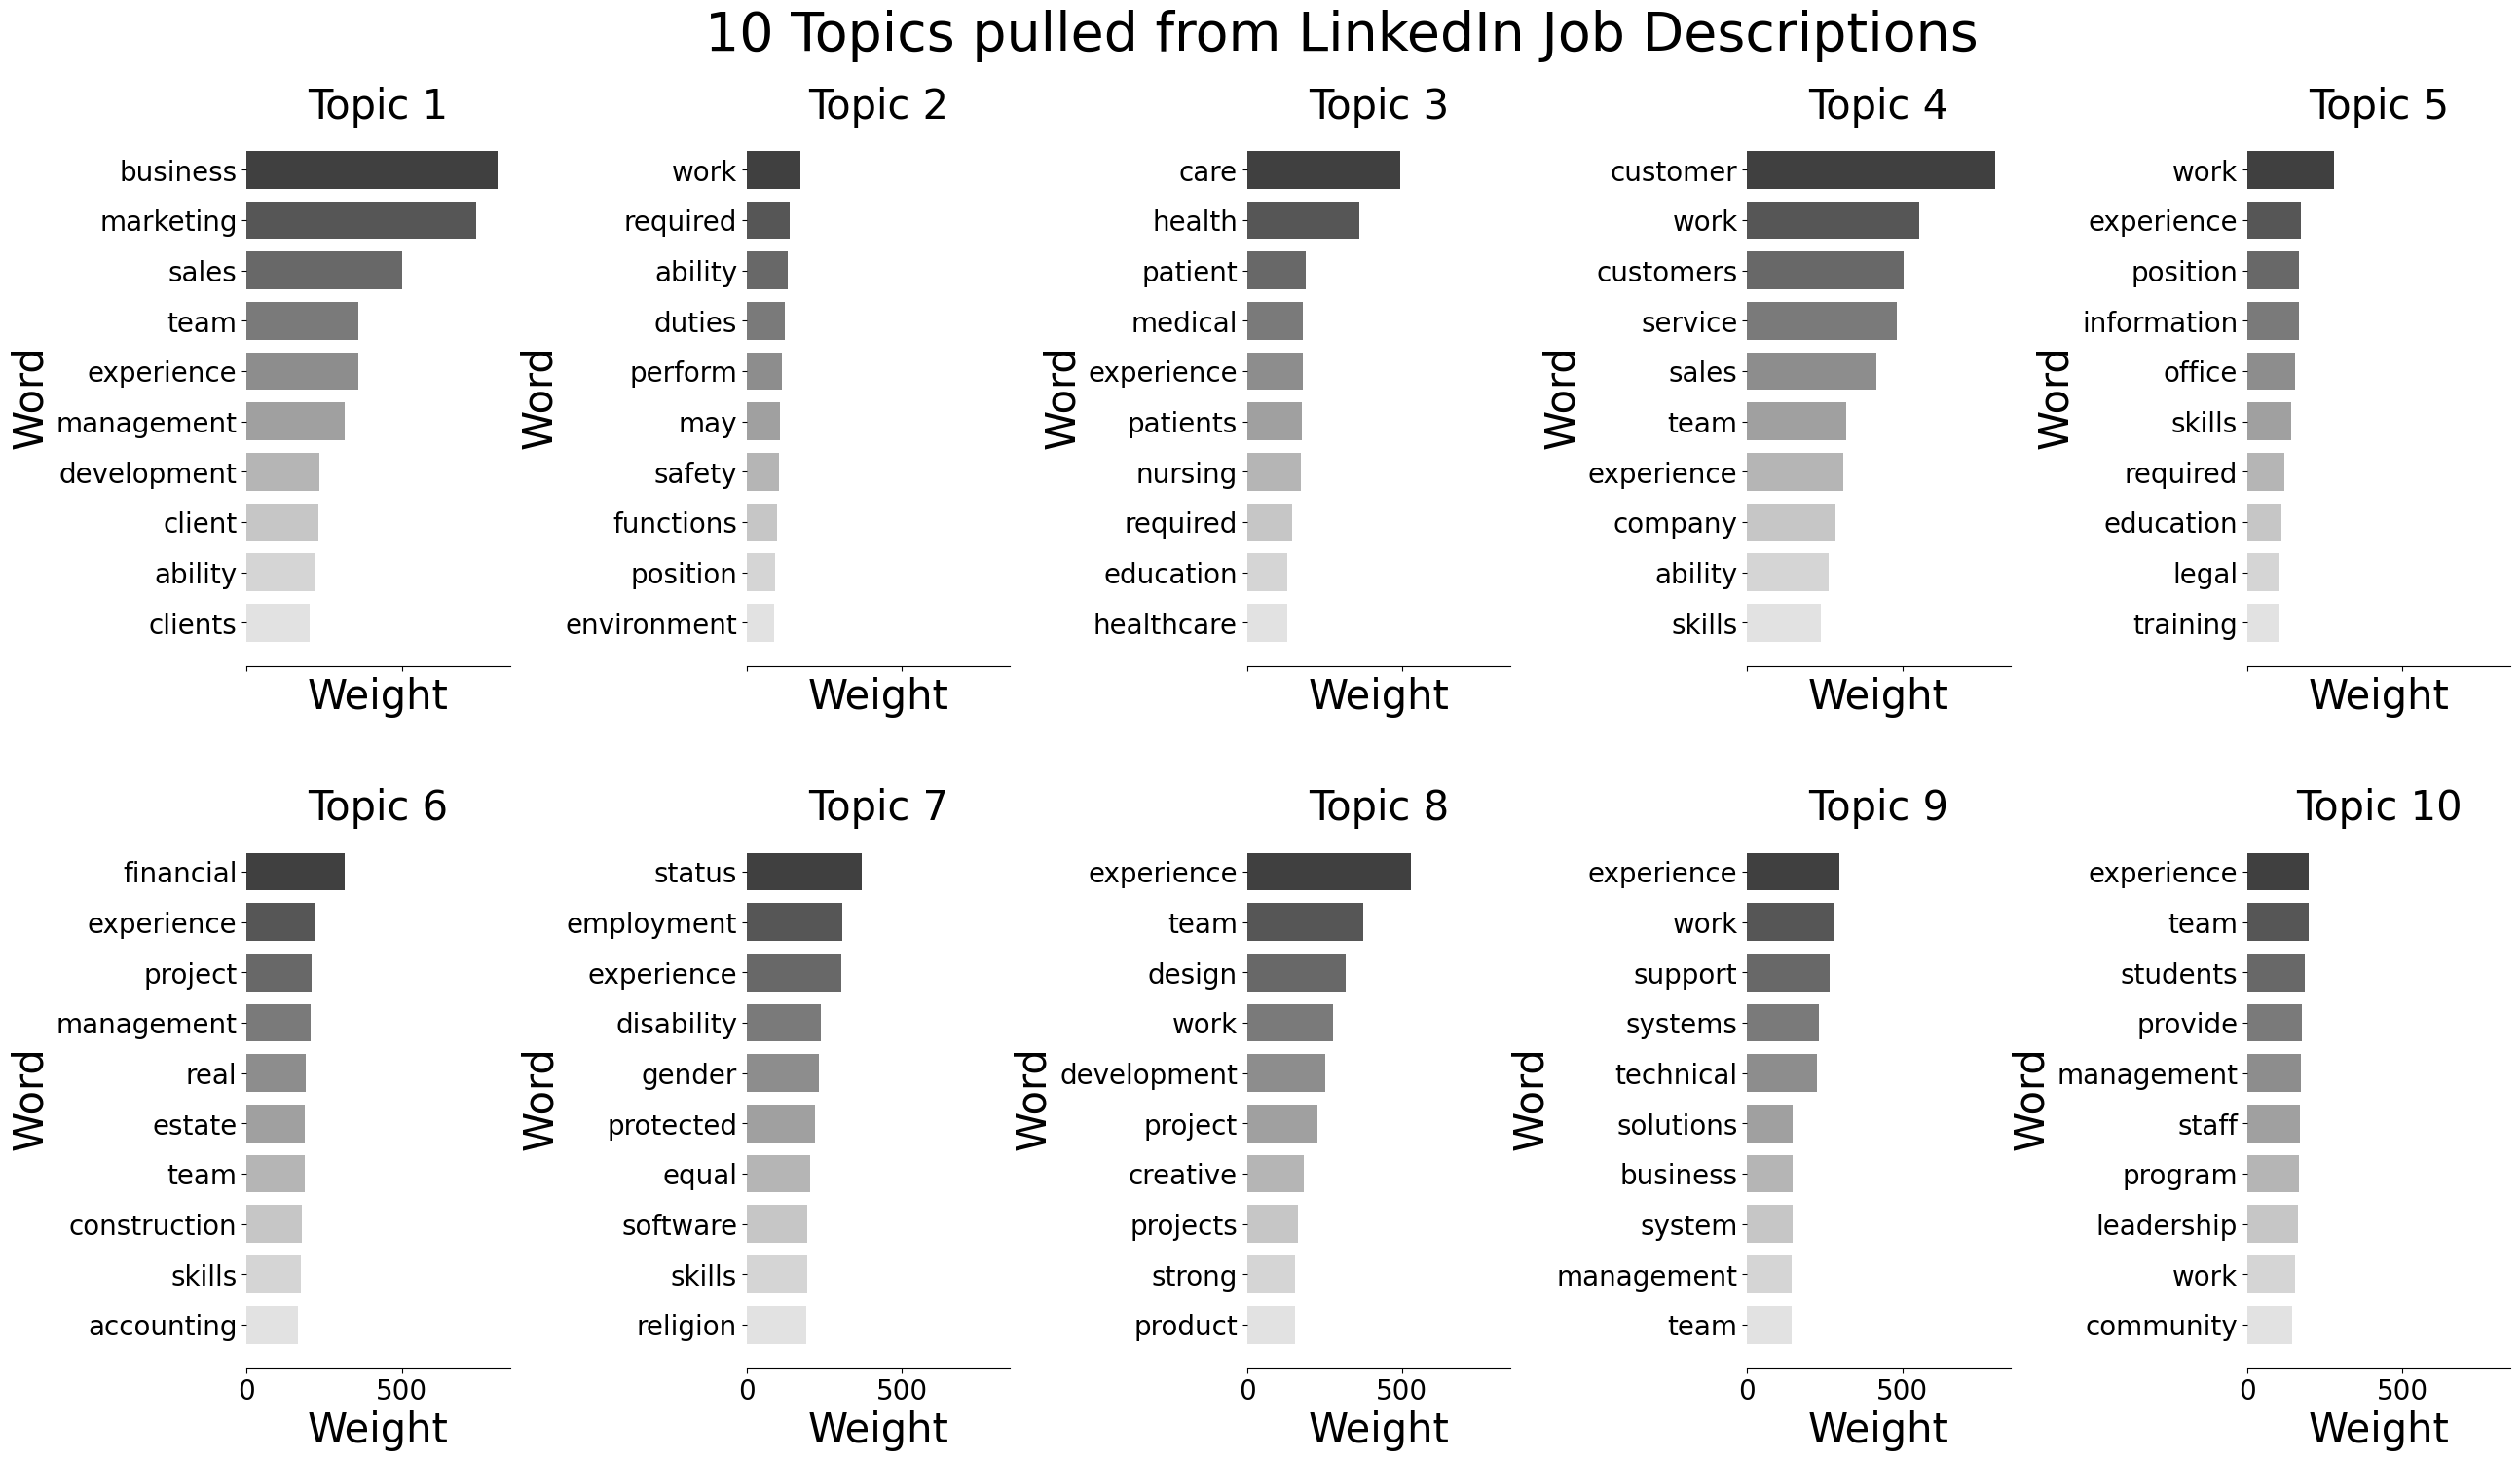

In [59]:
colormaps = ['plasma', 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu','GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    color = random.choice(colormaps)
    colors = plt.get_cmap(color)(np.linspace(0.2, 0.8, n_top_words))

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.75, color=colors)  # Specify the colors for each bar
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    # label x-axis for all plots
    for ax in axes:
        ax.set_xlabel("Weight", fontdict={"fontsize": 30})
        ax.set_ylabel("Word", fontdict={"fontsize": 30})
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


    # Plot the top words for each topic for both the course and job description models
plot_top_words(course_lda, catalog_vectorizer.get_feature_names_out(), no_top_words, f"{n_topics} Topics pulled from University of Illinois Course Catalog")
plot_top_words(job_lda, job_vectorizer.get_feature_names_out(), no_top_words, f"{n_topics} Topics pulled from LinkedIn Job Descriptions")


In [60]:
# Load the pre-trained spaCy model with word vectors
nlp = spacy.load("en_core_web_lg")

def get_topic_keywords(lda_model, feature_names, n_top_words=10):
    """
    Extracts the top N words for each topic from an LDA model.
    Args:
    lda_model (LatentDirichletAllocation): The trained LDA model.
    feature_names (list): List of feature names corresponding to the vocabulary.
    n_top_words (int): Number of top words to extract for each topic.
    Returns:
    list of list: A list of lists, where each sublist contains the top N words for a topic.
    """
    top_words = []
    for _, topic in enumerate(lda_model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words.append(top_features)
    return top_words

def get_average_vector(words):
    """
    Computes the average vector for a list of words using spaCy's word vectors.
    Args:
    words (list): List of words to compute the average vector for.
    Returns:
    np.ndarray: The average vector of the input words.
    """
    vectors = [nlp(word).vector for word in words if nlp(word).has_vector]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(nlp.vocab.vectors_length)

def topic_labels(top_words_list):
    labels = [', '.join(words) for words in top_words_list]
    return labels

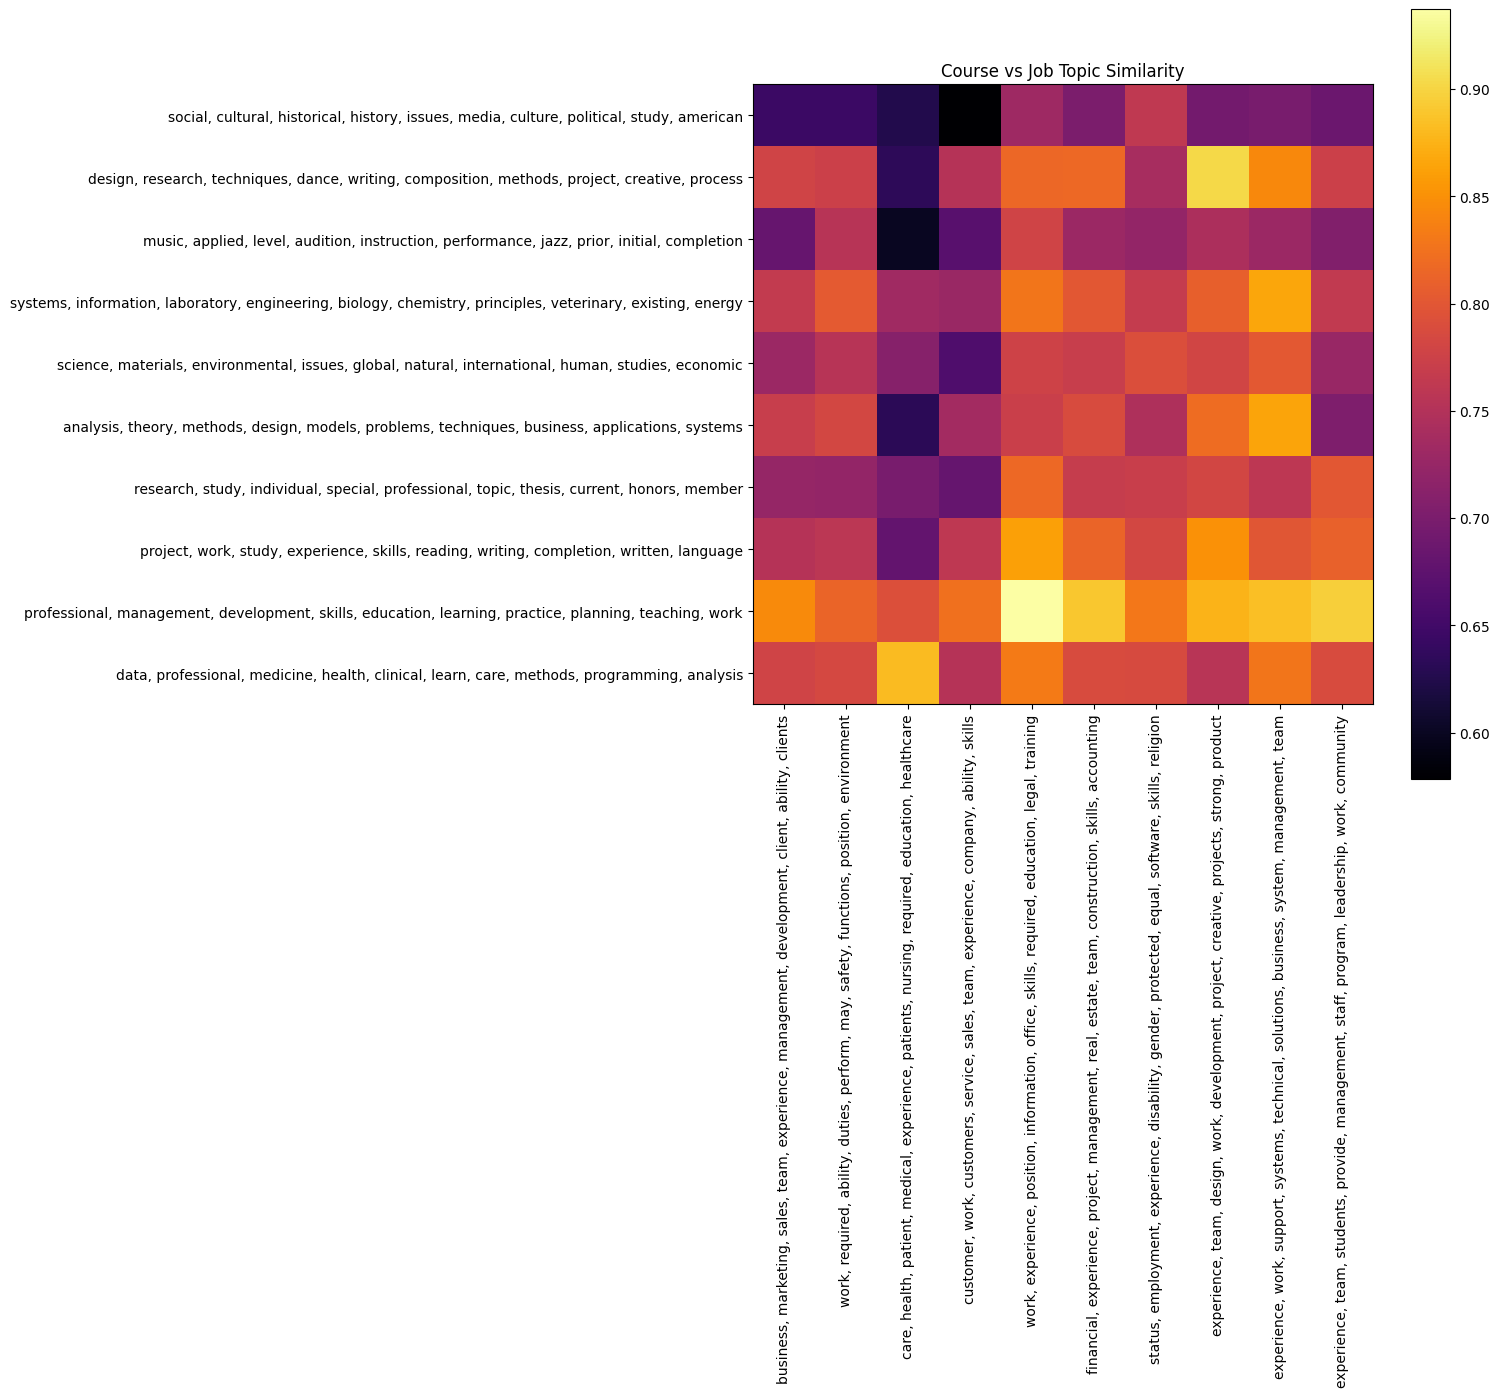

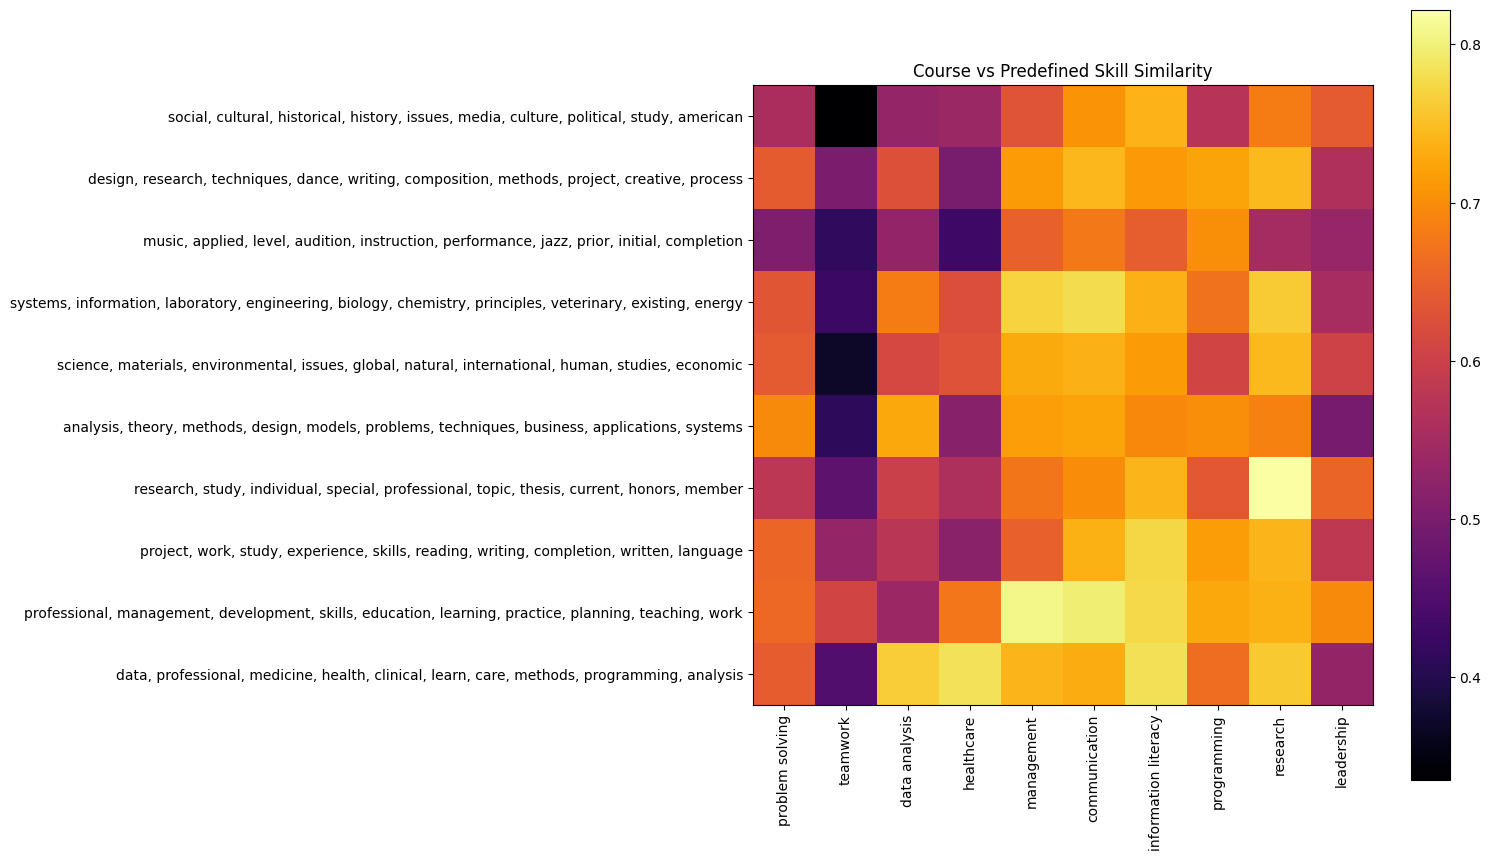

In [61]:

predefined_skills = ['problem solving', 'teamwork', 'data analysis', 'healthcare', 'management', 'communication', 'information literacy', 'programming', 'research', 'leadership']
skill_vectors = [get_average_vector([skill]) for skill in predefined_skills]


def create_cosine_similarity_heatmap(title, avg_vector1, avg_vector2, labels1, labels2):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    similarities = cosine_similarity(avg_vector1, avg_vector2)

    plt.imshow(similarities, cmap='inferno', interpolation='nearest')
    plt.yticks(range(len(labels1)), labels1)
    plt.xticks(range(len(labels2)), labels2, rotation=90)
    plt.colorbar()
    plt.show()


feature_names_courses = catalog_vectorizer.get_feature_names_out()
top_words_courses = get_topic_keywords(course_lda, feature_names_courses)
average_vector_courses = [get_average_vector(words) for words in top_words_courses]

feature_names_jobs = job_vectorizer.get_feature_names_out()
top_words_jobs = get_topic_keywords(job_lda, feature_names_jobs)
average_vector_jobs = [get_average_vector(words) for words in top_words_jobs]


# Then use cosine_similarity to compare average vectors between courses and jobs
similarities = cosine_similarity(average_vector_courses, average_vector_jobs)

course_labels = topic_labels(top_words_courses)
job_labels = topic_labels(top_words_jobs)

# Compare the similarity between course topics and job topics
create_cosine_similarity_heatmap('Course vs Job Topic Similarity', average_vector_courses, average_vector_jobs, course_labels, job_labels)

# Compare the similarity between course topics and predefined skills
create_cosine_similarity_heatmap('Course vs Predefined Skill Similarity', average_vector_courses, skill_vectors, course_labels, predefined_skills)




